In [1]:
# Install next 2 comments if first time
# nltk.download('punkt')
# !pip install lmppl
# !pip install textstat

#Needed for parse_sample
import statistics
import pandas as pd
import numpy as np
import re
from collections import Counter
import nltk
from nltk.tokenize import sent_tokenize
import lmppl
import warnings
from textstat import textstat

#needed for training/predictive models
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report, roc_auc_score, ConfusionMatrixDisplay, confusion_matrix,
    precision_recall_curve, auc, average_precision_score)
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

In [2]:
def parse_sample(sample):
    
    count_paragraphs = len(sample.split('\n\n'))
    
    #Count ocurrance of popular words
    sample_tolower = sample.lower()
    words = ['others', 'researchers','this', 'although', 'however', 'but', 'because']
    punctuation =[')', '-', ';', ':', '?',"'",'—']
    word_pattern = r'\b(?:' + '|'.join(words) + r')\b'
    punct_pattern = '[' + re.escape(''.join(punctuation)) + ']'
    pattern = f'{word_pattern}|{punct_pattern}'
    
    matches = re.findall(pattern, sample, flags =re.IGNORECASE)
    normalize_matches = [match.lower() for match in matches]
    count_wordfind = Counter(normalize_matches)
    
    pop_ai = count_wordfind.get("others", 0) + count_wordfind.get("researchers", 0) + count_wordfind.get("'", 0) + count_wordfind.get("—", 0)
    pop_hu = sum(count_wordfind.values()) - pop_ai
    #print(count_wordfind)
    
    #perplexity score for whole paragraph
    #lower score means the algorithm is more confident predicting next word,
    #thus will then indicate likelyhood of ai generated text
    #https://www.geeksforgeeks.org/perplexity-for-llm-evaluation/
    scorer1 = lmppl.LM('gpt2')
    perp = scorer1.get_perplexity(sample)   
    
    #Gather statistics: word count, sentence count, paragraph count
    into_paragraphs = sample.split('\n\n')
    sentence_per_paragraph = []
    words_per_para = []
    words_per_sentence = []
    char_count = []
    
    for many in into_paragraphs:
        sentences = sent_tokenize(many)
        sentence_per_paragraph.append(len(sentences))
        
        paragraph_word_count = 0
        sentence_lengths = []    
        for sentence in sentences:
            #print(sentence)
            words_in_sentence = sentence.strip().split()
            word_count = len(words_in_sentence)
            if word_count > 0:
                sentence_lengths.append(word_count)
                paragraph_word_count += word_count      
        words_per_para.append(paragraph_word_count)
        words_per_sentence.append(sentence_lengths)
        #print()
        
#     print('Sent Per Para: ' + str(sentence_per_paragraph))
#     print('Word Per Para: ' + str(words_per_para))
#     print('Word Per Sent' + str(words_per_sentence))
    
    # Flatten the list of lists to get all sentence word counts
    all_sentence_lengths = [length for para in words_per_sentence for length in para]

    #Get mean of words per sentence and standard deviation of words per sentence
    if all_sentence_lengths:
        mean_words_per_sentence = sum(all_sentence_lengths) / len(all_sentence_lengths)
        std_dev_words_per_sentence = statistics.stdev(all_sentence_lengths)
    else:
        mean_words_per_sentence = 0
        std_dev_words_per_sentence = 0
        
    flesch_kincaid = textstat.flesch_kincaid_grade(sample)
    gunning_fog = textstat.gunning_fog(sample)
    smog_index = textstat.smog_index(sample)
        
    #Insert into dataframe: ['perp', 'para_count', 'sentence_per_para', 'words_per_para', 'words_per_sent', 'avg_sent_len', 'std_sent']
    detection_stats_DF.loc[len(detection_stats_DF)] = [perp, count_paragraphs, sentence_per_paragraph[0], words_per_para[0], words_per_sentence, round(mean_words_per_sentence, 2), round(std_dev_words_per_sentence, 2), count_wordfind, pop_hu, pop_ai, flesch_kincaid, gunning_fog, smog_index]
    

In [3]:
# Call to print confusion matrix during train/tests
def show_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(title)
    plt.show()

In [4]:
#Preparing Training_data.csv Data
detection_stats_DF = pd.DataFrame(columns=['perplexity_score','para_count', 'sentence_per_para', 'words_per_para', 'words_per_sent', 'avg_sent_len', 'std_sent', 'popular_words', 'pop_hu', 'pop_ai', 'flesch_kincaid', 'gunning_fog', 'smog_index'])
training_df = pd.read_csv('Training_data.csv')
training_hu_df = training_df.loc[training_df["Human OR AI"] == "Human"]
training_ai_df = training_df.loc[training_df["Human OR AI"] == "AI"]

warnings.filterwarnings("ignore", category=DeprecationWarning)

for index, x in training_hu_df.iterrows():
    parse_sample(x["Document"])

human_df = detection_stats_DF.copy()
human_df.insert(loc=1, column='is_ai', value=0)

detection_stats_DF = detection_stats_DF.drop(detection_stats_DF.index)

for index, x in training_ai_df.iterrows():
    parse_sample(x["Document"])
ai_df = detection_stats_DF.copy()
ai_df.insert(loc=1, column='is_ai', value=1)

data = pd.concat([human_df, ai_df])
data = data.reset_index(drop=True)

D:\mattl\CONDA\Lib\site-packages\transformers\models\auto\tokenization_auto.py:631: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
D:\mattl\CONDA\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
D:\mattl\CONDA\Lib\site-packages\transformers\models\auto\configuration_auto.py:995: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
D:\mattl\CONDA\Lib\site-packages\transformers\models\auto\auto_factory.py:460: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
D:\mattl\CONDA\Lib\site-packages\transformers\utils\generic.py:260: FutureWarning: `torch.utils._pytree._register_pytre

D:\mattl\CONDA\Lib\site-packages\transformers\utils\hub.py:373: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
Using pad_token, but it is not set yet.
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embeding dimension will be 50258. This might induce some performance reduction as *Tensor Cores* will not be available. For more details  about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.45it/s]
D:\mattl\CONDA\Lib\site-packages\transformers\models\auto\tokenization_auto.py:631: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
D:\ma

D:\mattl\CONDA\Lib\site-packages\transformers\utils\hub.py:373: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
Using pad_token, but it is not set yet.
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embeding dimension will be 50258. This might induce some performance reduction as *Tensor Cores* will not be available. For more details  about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.28it/s]
D:\mattl\CONDA\Lib\site-packages\transformers\models\auto\tokenization_auto.py:631: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
D:\ma

D:\mattl\CONDA\Lib\site-packages\transformers\utils\hub.py:373: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
Using pad_token, but it is not set yet.
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embeding dimension will be 50258. This might induce some performance reduction as *Tensor Cores* will not be available. For more details  about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.58it/s]
D:\mattl\CONDA\Lib\site-packages\transformers\models\auto\tokenization_auto.py:631: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
D:\ma

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.33      1.00      0.50         1

    accuracy                           0.50         4
   macro avg       0.67      0.67      0.50         4
weighted avg       0.83      0.50      0.50         4

ROC AUC Score: 1.0
    is_ai   p_score
0       0  0.632388
1       0  0.290528
2       0  0.172546
3       0  0.185285
4       0  0.505816
5       0  0.681886
6       0  0.200661
7       0  0.136844
8       1  0.966676
9       1  0.994431
10      1  0.798921
11      1  0.720908
12      1  0.686535
13      1  0.758613
14      1  0.764142
15      1  0.872753


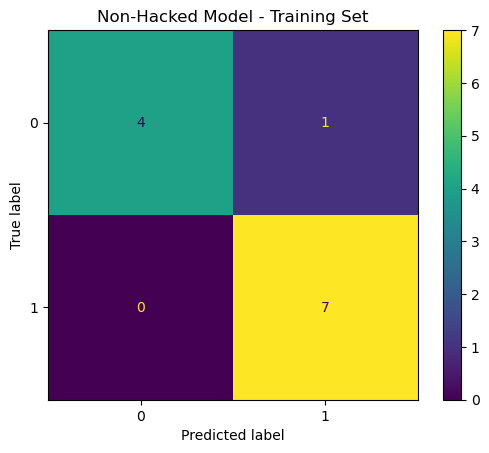

In [5]:
#P-Score, non-hacked model, Train_data dataframe (data)
features = [
    'perplexity_score', 'para_count', 'sentence_per_para', 'words_per_para',
    'avg_sent_len', 'std_sent', 'pop_hu', 'pop_ai',
    'flesch_kincaid', 'gunning_fog', 'smog_index'
]
target = 'is_ai'

X = data[features]
y = data[target]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

p_scores = model.predict_proba(X_scaled)[:, 1]
data['p_score'] = p_scores

y_pred_test = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred_test))
print("ROC AUC Score:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
print(data[['is_ai', 'p_score']])
show_conf_matrix(y_train, model.predict(X_train), "Non-Hacked Model - Training Set 50%")


In [6]:
#Get heuristics of csv from parse_sample('text')
test_df = pd.read_csv('Test_data.csv')
detection_stats_DF = detection_stats_DF.drop(detection_stats_DF.index)
for index, x in test_df.iterrows():
    parse_sample(x["Document"])

#prepare data for prediction
data2 = detection_stats_DF.copy()
data2 =data2.drop(columns=['words_per_sent', 'popular_words'])

D:\mattl\CONDA\Lib\site-packages\transformers\models\auto\tokenization_auto.py:631: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
D:\mattl\CONDA\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
D:\mattl\CONDA\Lib\site-packages\transformers\models\auto\configuration_auto.py:995: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
D:\mattl\CONDA\Lib\site-packages\transformers\models\auto\auto_factory.py:460: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
D:\mattl\CONDA\Lib\site-packages\transformers\utils\hub.py:373: FutureWarning: The `use_auth_token` argument is depreca

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.14it/s]
D:\mattl\CONDA\Lib\site-packages\transformers\models\auto\tokenization_auto.py:631: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
D:\mattl\CONDA\Lib\site-packages\huggingface_hub\file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
D:\mattl\CONDA\Lib\site-packages\transformers\models\auto\configuration_auto.py:995: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
D:\mattl\CONDA\Lib\site-packages\transformers\models\auto\auto_factory.py:460: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(

    p_score  predicted_is_ai
0  0.471121                0
1  0.792734                1
2  0.895294                1
3  0.862692                1
4  0.743226                0
5  0.983746                1
6  0.733656                0
7  0.570674                0


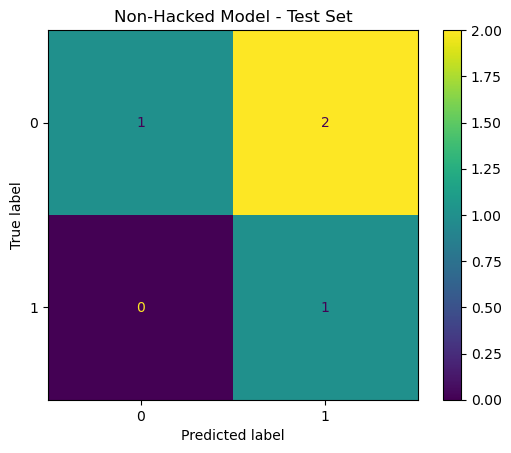

In [7]:
# Test_data (data2) with non-p-hacked version:
features = [
    'perplexity_score', 'para_count', 'sentence_per_para', 'words_per_para',
    'avg_sent_len', 'std_sent', 'pop_hu', 'pop_ai',
    'flesch_kincaid', 'gunning_fog', 'smog_index'
]


assert all(f in data2.columns for f in features), "Missing required features in new_data"
X_new_scaled = scaler.transform(data2[features])
data2['p_score'] = model.predict_proba(X_new_scaled)[:, 1]
threshold = 0.75
data2['predicted_is_ai'] = (data2['p_score'] >= threshold).astype(int)

print(data2[['p_score', 'predicted_is_ai']])
show_conf_matrix(y_test, model.predict(X_test), "Non-Hacked Model - Test Set 50%")

#Adjusting threshold has given 2 incorrect and 6 correct predictions. 1 false positive and 1 false negative
#overall accuracy of 75%

=== P-Hacked Model: Full Training Set ===
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.75      0.75         8
           1       0.75      0.75      0.75         8

    accuracy                           0.75        16
   macro avg       0.75      0.75      0.75        16
weighted avg       0.75      0.75      0.75        16

ROC AUC Score: 0.7265625
P-value: 0.1409851421907773
   is_ai  pop_ai  p_hacked_score  predicted_is_ai_p_hacked
0      0       4            1.00                         1
1      0       0            0.00                         0
2      0       2            0.50                         1
3      0       1            0.25                         0
4      0       1            0.25                         0
5      0       1            0.25                         0
6      0       1            0.25                         0
7      0       0            0.00                         0
8      1       2        

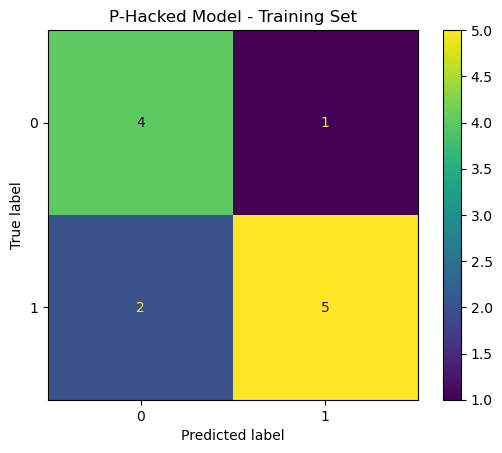

In [10]:
#Training P hacked version : training data

df = data.copy()

# Using pop_ai
df['p_hacked_score'] = df['pop_ai'] / df['pop_ai'].max()
X_train, X_test, y_train, y_test = train_test_split(df[['p_hacked_score']], df['is_ai'], test_size=0.2, random_state=42)

threshold = 0.5
df['predicted_is_ai_p_hacked'] = (df['p_hacked_score'] >= threshold).astype(int)

print("=== P-Hacked Model: Full Training Set ===")
print("Classification Report:")
print(classification_report(df['is_ai'], df['predicted_is_ai_p_hacked']))
print("ROC AUC Score:", roc_auc_score(df['is_ai'], df['p_hacked_score']))

ai_scores = df[df['is_ai'] == 1]['p_hacked_score']
human_scores = df[df['is_ai'] == 0]['p_hacked_score']
t_stat, p_val = ttest_ind(ai_scores, human_scores)
print("P-value:", p_val)

print(df[['is_ai', 'pop_ai', 'p_hacked_score', 'predicted_is_ai_p_hacked']].head(10))
show_conf_matrix(y_train, (X_train['p_hacked_score'] >= threshold).astype(int), "P-Hacked Model - Training Set 50%")



   pop_ai  p_hacked_score  predicted_is_ai_p_hacked
0       0            0.00                         0
1       2            0.50                         1
2       3            0.75                         1
3       2            0.50                         1
4       1            0.25                         0
5       4            1.00                         1
6       1            0.25                         0
7       1            0.25                         0


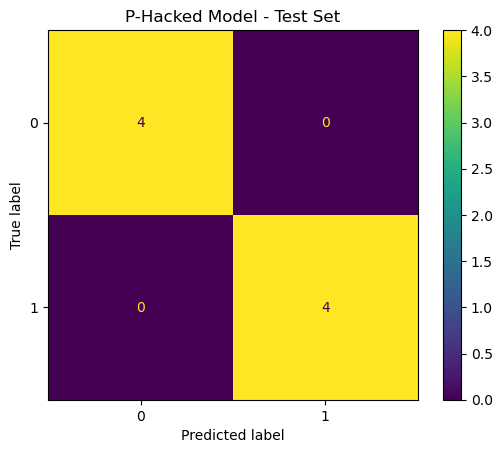

In [15]:
#Testing P-Hack version on test_data.csv. Similar accuracy as training results
df = data2.copy()
df.rename(columns={'predicted_is_ai': 'is_ai'}, inplace=True)

max_pop_ai = data['pop_ai'].max()  # Use max from training data
df['p_hacked_score'] = df['pop_ai'] / max_pop_ai

#Same threshold as training: 0.5
threshold = 0.5
df['predicted_is_ai_p_hacked'] = (df['p_hacked_score'] >= threshold).astype(int)

print(df[['pop_ai', 'p_hacked_score', 'predicted_is_ai_p_hacked']])
show_conf_matrix(df['is_ai'], df['predicted_is_ai_p_hacked'], "P-Hacked Model - Test Set 50%")

In [22]:
# Simulating data for different prevalence levels
def simulate_prevalence(df, ai_percentage):

    ai_samples = df[df['is_ai'] == 1]
    human_samples = df[df['is_ai'] == 0]
    
    num_ai = max(1, int(len(df) * ai_percentage))
    num_human = len(df) - num_ai
    
    sampled_ai = ai_samples.sample(n=num_ai, random_state=42, replace = True)
    sampled_human = human_samples.sample(n=num_human, random_state=42, replace=True)
    simulated_df = pd.concat([sampled_ai, sampled_human]).sample(frac=1, random_state=42)
    return simulated_df

# Simulating for 25% AI (75% Human) and 6.125% AI (93.875% Human)
df_25 = simulate_prevalence(df, 0.25)
df_6_125 = simulate_prevalence(df, 0.06125)
print(f"25% AI - Samples: {len(df_25)}, AI: {len(df_25[df_25['is_ai'] == 1])}, Human: {len(df_25[df_25['is_ai'] == 0])}")
print(f"6.125% AI - Samples: {len(df_6_125)}, AI: {len(df_6_125[df_6_125['is_ai'] == 1])}, Human: {len(df_6_125[df_6_125['is_ai'] == 0])}")


25% AI - Samples: 8, AI: 2, Human: 6
6.125% AI - Samples: 8, AI: 1, Human: 7


D:\mattl\CONDA\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


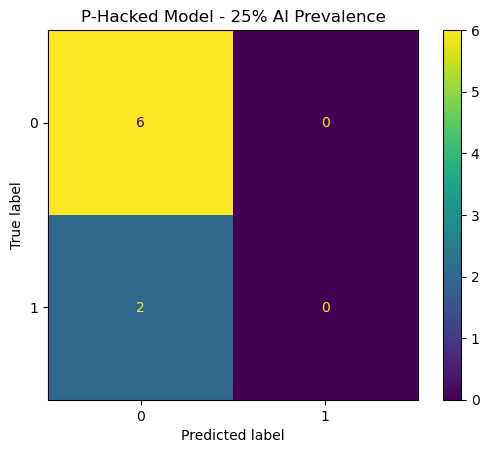

D:\mattl\CONDA\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


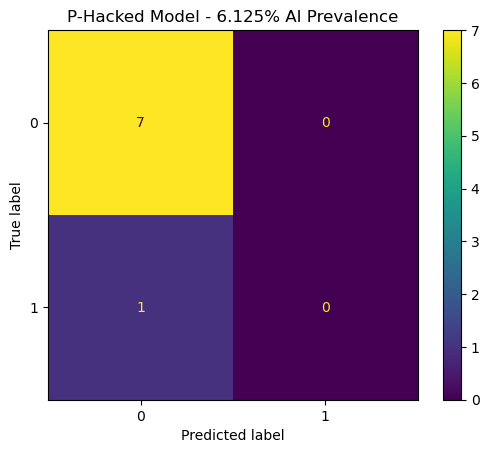

In [25]:
#For 25% AI and 6.125% AI prevalence
#Thresholds do not need to be adjusted
def get_model_predictions_and_cm(simulated_df, model):
    X = simulated_df[['pop_ai', 'perplexity_score', 'para_count', 'sentence_per_para', 
                      'words_per_para', 'avg_sent_len', 'std_sent', 'pop_hu', 
                      'flesch_kincaid', 'gunning_fog', 'smog_index']]
    y_true = simulated_df['is_ai']
    y_pred = (model.predict(X) >= 0.5).astype(int)  # Use threshold 0.5 for now
    return y_true, y_pred

# 25% AI prevalence
y_true_25, y_pred_25 = get_model_predictions_and_cm(df_25, model)
show_conf_matrix(y_true_25, y_pred_25, title="P-Hacked Model - 25% AI Prevalence")

# 6.125% AI prevalence
y_true_6_125, y_pred_6_125 = get_model_predictions_and_cm(df_6_125, model)
show_conf_matrix(y_true_6_125, y_pred_6_125, title="P-Hacked Model - 6.125% AI Prevalence")
